# Derive models of drone

Do all imports.

In [2]:
import sympy as sym
import numpy as np

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Dynamic model

Define physical parameters.

In [3]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive the equations of motion:

In [4]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

Here is the function $f$:

In [5]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

## Sensor model

Define the sensor model.

In [6]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi, \theta, \phi)$$

Here is the function $g$:

In [7]:
g

Matrix([
[p_x + 7*sin(phi)*sin(theta)*cos(psi)/40 - 7*sin(psi)*cos(phi)/40],
[p_y + 7*sin(phi)*sin(psi)*sin(theta)/40 + 7*cos(phi)*cos(psi)/40],
[                                  p_z + 7*sin(phi)*cos(theta)/40],
[p_x - 7*sin(phi)*sin(theta)*cos(psi)/40 + 7*sin(psi)*cos(phi)/40],
[p_y - 7*sin(phi)*sin(psi)*sin(theta)/40 - 7*cos(phi)*cos(psi)/40],
[                                  p_z - 7*sin(phi)*cos(theta)/40]])

## Find A and B

In [8]:
from scipy.linalg import solve_continuous_are
import numpy.linalg as la

m = (p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z)
n = (tau_x,tau_y,tau_z,f_z)
mn = (p_x,p_y,p_z,psi,theta,phi,v_x,v_y,v_z,w_x,w_y,w_z,tau_x,tau_y,tau_z,f_z)

An = sym.lambdify(mn, f.jacobian(m))
Bn = sym.lambdify(mn, f.jacobian(n))

A = An(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,(0.5 * 9.81))
B = Bn(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,(0.5 * 9.81))
print("Matrix A:")
print(A.tolist())
# display(sym.Matrix(A))
print("Matrix B:")
print(B.tolist())
# display(sym.Matrix(B))

Matrix A:
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Matrix B:
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 2.0], [434.7826086956522, 0.0, 0.0,

In [9]:
def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = la.inv(R) @ B.T @ P
    return K

In [10]:
Q = np.diag((1,1,10,10,10,10,0.1,0.1,5,1,1,1)) * 1
R = np.diag((90,90,90,1)) * 1

W = B
for i in range(1, A.shape[0]):
    W = np.block([W, la.matrix_power(A, i) @ B])

if W.shape[0] == la.matrix_rank(W):
    print("System is controllable.")
    K = lqr(A,B,Q,R)
    print("Matrix K:")
    print(K.tolist())
    #display(sym.Matrix(K))
else:
    print("System is not controllable.")

System is controllable.
Matrix K:
[[-9.246571817929257e-16, -0.10540925533894613, 5.398232210805946e-16, -1.4583792560586354e-16, -1.857346959534405e-15, 0.6205079918071856, -5.776527349259622e-16, -0.12019122153722238, 3.3017985246897834e-16, 0.11817549607860407, -5.837503214892338e-18, -2.82719602063144e-17], [0.10540925533894512, -5.769881959011142e-17, 8.553585282244591e-16, 1.9640268363706907e-16, 0.6205079918071827, -1.166093308976342e-16, 0.12019122153722185, 1.6613771570755613e-16, 4.055473058598874e-16, -5.837503214892338e-18, 0.11817549607860398, -2.404474182943486e-17], [-9.369114233964584e-17, -1.0170760216329116e-17, 5.01313489700937e-17, 0.33333333333333515, -1.043011956898743e-15, -1.7778481831812833e-16, -4.595604546334388e-16, 5.5463418338919e-17, 1.2377494655290135e-16, -1.625637711863078e-17, -1.3825726551925042e-17, 0.1173787790777271], [8.732798999784058e-16, -3.5307094435148197e-15, 3.162277660168387, 9.422521527941734e-16, 7.580428308530666e-15, 7.461953032974458

In [11]:
o_e = g.subs({p_x: 0, p_y: 0, p_z: 0, psi: 0, theta: 0, phi: 0})
o_e = np.array(o_e.T.evalf())
o_e = np.array(o_e[0])
print(o_e)

[0 0.175000000000000 0 0 -0.175000000000000 0]


In [12]:
m = (p_x,p_y,p_z,psi,theta,phi)
n = ()
mn = (p_x,p_y,p_z,psi,theta,phi)

# No D because there are no inputs in the sensor model
Cn = sym.lambdify(mn, g.jacobian(m))
#Dn = sym.lambdify(mn, f.jacobian(n))

C = Cn(0,0,1,0,0,0)
C = np.hstack((C, np.zeros((C.shape[0], 6))))
#D = Dn(0,0,0,0,0,0)
print("Matrix C:")
print(C.tolist())
#display(sym.Matrix(C))
# print("Matrix D:")
# print(D.tolist())

Matrix C:
[[1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, -0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.175, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, -0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [13]:
# Define weight matrices for LQR
Q0 = np.eye(C.shape[0]) * 1
R0 = np.eye(A.shape[0]) * 1

O = C
for i in range(1, A.shape[0]):
    O = np.vstack([O, C @ la.matrix_power(A, i)])

if A.shape[0] == la.matrix_rank(O):
    print("System is observable.")
    L = lqr(A.T, C.T, la.inv(R0), la.inv(Q0)).T
    print("Matrix L:")
    print(L.tolist())
    #display(sym.Matrix(L))
else:
    print("System is not observable, the rank is", la.matrix_rank(O))

System is observable.
Matrix L:
[[2.9753760189621543, -6.580037699041667e-16, 1.6001907839427215e-16, 2.9753760189621543, -6.580037699041667e-16, -1.600190783942726e-16], [-1.0577005754028578e-15, 2.9271137918023884, -0.21976816368497426, -2.583069644054755e-16, 2.9271137918023884, 0.21976816368497476], [1.8552877919436988e-18, 2.5078636764011776e-16, 1.0986841134678103, -1.855287791944138e-18, 2.5078636764011776e-16, 1.0986841134678103], [-2.1308707558669164, 2.283981745706807e-15, -2.570753396758938e-16, 2.1308707558669164, 2.283981745706807e-15, 2.3587205062510615e-16], [1.3054317390112393, -7.3161859104167e-16, 2.3323214856858186e-16, 1.3054317390112393, -7.3161859104167e-16, -2.332321485685815e-16], [1.1608684288320565e-15, -1.2558180781998545, 0.3042973803557048, 6.679210385310564e-16, -1.2558180781998545, -0.30429738035570536], [8.352862454215117, -3.8711592794376034e-15, 1.0519782928631784e-15, 8.352862454215117, -3.8711592794376034e-15, -1.0519782928631782e-15], [-5.2979177965

In [14]:
print(la.eigvals(A - B@K).real < 0)
print(la.eigvals(A - L@C).real < 0)

[ True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True]


# Setup and Run the Simulation

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

seed = secrets.randbits(32)
seed = 3608613279
print(seed)

simulator = ae353_drone.Simulator(seed=seed)

simulator.add_view(
    'my_start_view',  # name of view (must be unique)
    'top',          # type of view (start, top, right, left, or back)
)
simulator.clear_drones()

3608613279
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [16]:
class Controller:
    def __init__(self, dt = 0.04):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.o_e = o_e
        self.dt = dt
        self.xhat = np.zeros(12)
        self.t = 0

    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0., # <-- how much red (between 0 and 1)
            1., # <-- how much green (between 0 and 1)
            0., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        self.t = 0
        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0])

    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        # Get estimated position
        phat = xhat[0:3]

        # Choose goal
        pgoal = pos_ring
        
        ##############################
        
        # Define parameters
        k_att = 2.0
        k_rep = 0.3
        k_des = 2.5
        r_drone = 0.25  # <-- radius of a sphere that would completely contain each drone
        r_ring = 1.0    # <-- radius of each small ring
        
        # Get attractive part
        grad_h_att = k_att * ((phat - pgoal) / np.linalg.norm(phat - pgoal))
        
        # Get repulsive part
        # - Initialize the gradient
        grad_h_rep = np.zeros(3)
        # - Add repulsive part for each other drone
        for q in pos_others:
            pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
            dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
            d = np.linalg.norm(phat - pobst) - r_drone
            grad_h_rep += - k_rep * (1 / d**2) * dgrad
        # - Add repulsive part for next ring
        q = pos_ring
        n = dir_ring
        v_n = np.dot(n, phat - q) * n
        v_t = (phat - q) - v_n
        if np.linalg.norm(v_t) > r_ring:
            pobst = q + v_t
        else:
            pobst = q + r_ring * (v_t / np.linalg.norm(v_t))
        dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
        d = np.linalg.norm(phat - pobst) - r_drone
        grad_h_rep += - k_rep * (1 / d**2) * dgrad
        # - Add repulsive part for ground
        q = np.array([0., 0., 0.])
        n = np.array([0., 0., 1.])
        pobst = phat - np.dot(n, phat - q) * n
        dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
        d = np.linalg.norm(phat - pobst) - r_drone
        grad_h_rep += - k_rep * (1 / d**2) * dgrad
        # n.dot(p - q)
        grad_h_rep += np.zeros(3)           # <-- REPLACE WITH YOUR CODE
        #print(grad_h_rep)
        # Get desired position
        pdes = phat - k_des * (grad_h_att + grad_h_rep)
        
        ##############################
        
        # Make sure desired position is not too far away
        emax = 1.6
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
        
        
        if la.norm(pgoal - phat,ord=2) < .7:
            #print('go thro')
            pdes += dir_ring * .3

        #print(la.norm(pdes - phat,ord=2))
        # Get desired state
        xdes = np.zeros(12)
        xdes[0:3] = pdes
        return xdes

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on left rotor (meters),
                measured y position of marker on left rotor (meters),
                measured z position of marker on left rotor (meters),
                measured x position of marker on right rotor (meters),
                measured y position of marker on right rotor (meters),
                measured z position of marker on right rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all other active drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """

        xdes = self.get_xdes(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)
        u = -self.K @ (self.xhat - xdes)
        
        y = pos_markers - np.array([0,.175,0,0,-.175,0])
        # print(y)

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )

        tau_x, tau_y, tau_z, f_z = u + np.array([0,0,0,0.5*9.81])

        return tau_x, tau_y, tau_z, f_z

In [17]:
simulator.add_drone(Controller, 'template', 'template.png')
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': 0.,
            'p_y': 0.,
            'p_z': 1,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 0.,
            'p_y_meas': 0.,
            'p_z_meas': 1,
            'yaw_meas': 0.,
        },
    },
)
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
    error_on_inactive=False, # <-- allow inactivity
)
simulator.run(
    max_time=60.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)

Simulated 1501 time steps in 60.0411 seconds (24.9996 time steps per second)


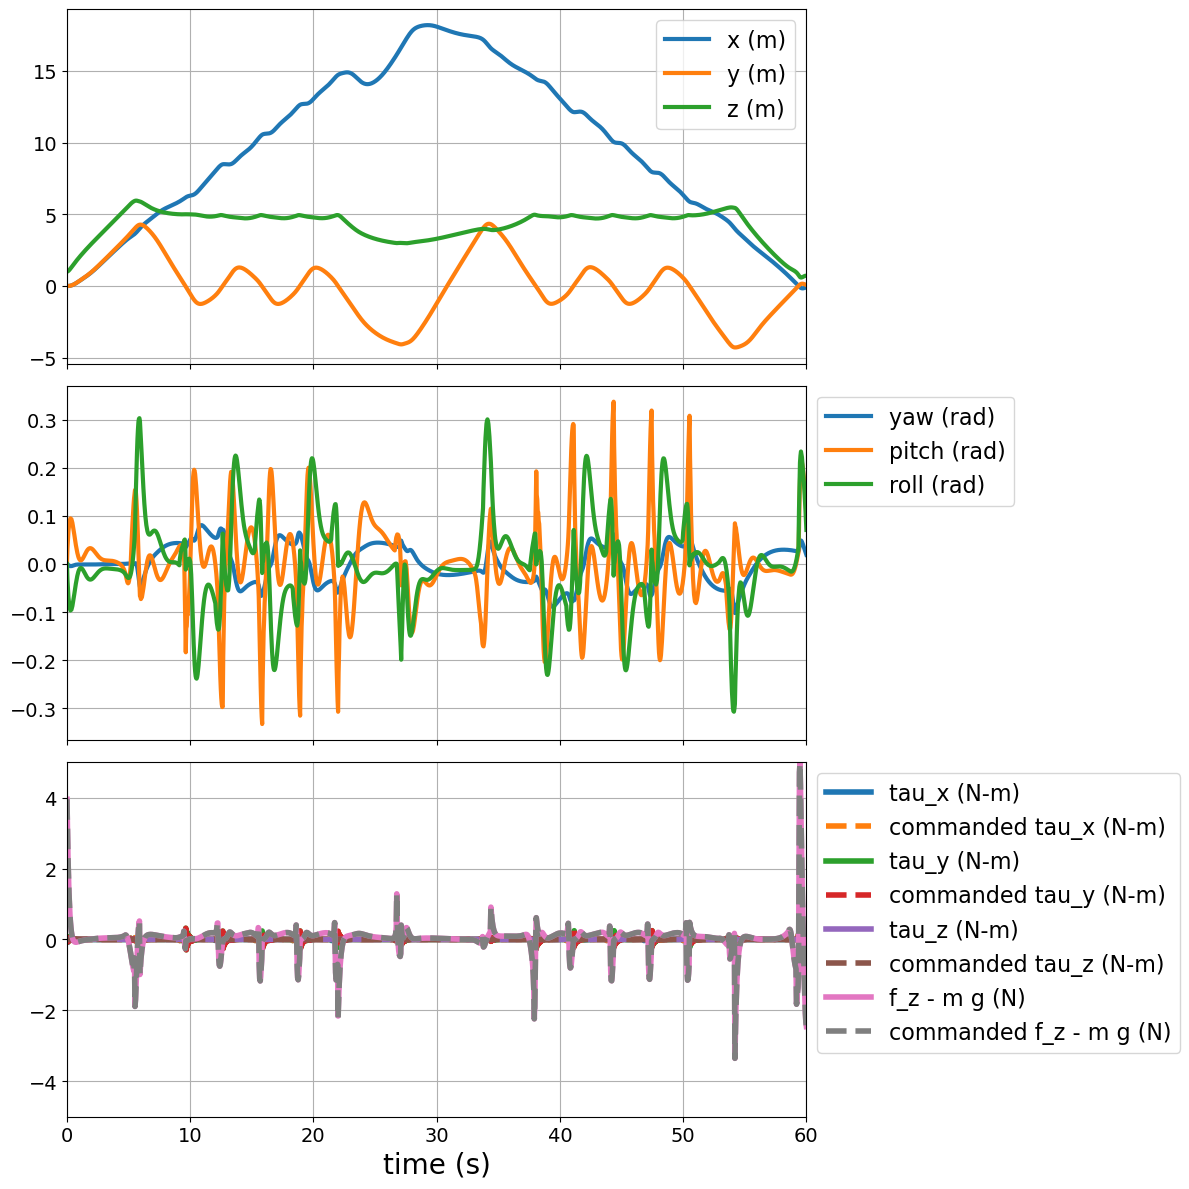

In [19]:
data = simulator.get_data('template')
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Measurements
# ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{L, x}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{L, y}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{L, z}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{R, x}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{R, y}$')
# ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{R, z}$')
# ax_meas.grid()
# ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
# ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], np.array(data['f_z']) - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4)
ax_act.plot(data['t'], np.array(data['f_z_cmd']) - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4)
ax_act.set_ylim(-5, 5)  # Set both y-limits
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)



# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

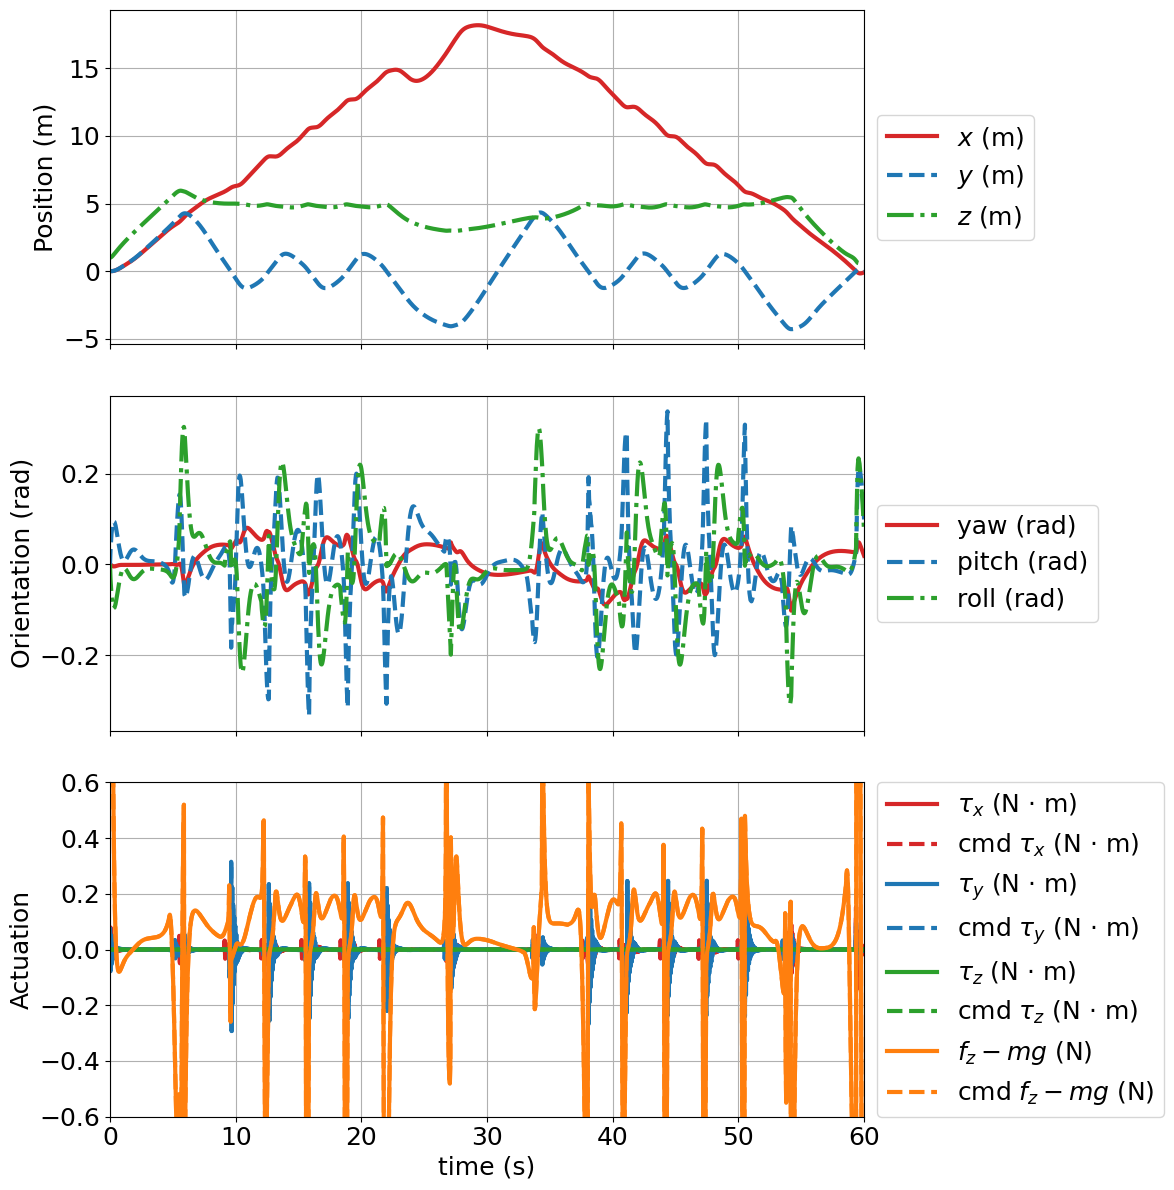

In [24]:
# Define a variable to control font size locally
font_size = 18

# Define consistent colors
color_x = 'tab:red'
color_y = 'tab:blue'
color_z = 'tab:green'
color_cmd = 'tab:orange'

# Define consistent linestyles
linestyles = ['-', '--', '-.', ':']

# Load data
data = simulator.get_data('template')

# Create figure with three subplots
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# ---- 1. Position ----
ax_pos.plot(data['t'], data['p_x'], label=r'$x$ (m)', linewidth=3, color=color_x, linestyle=linestyles[0])
ax_pos.plot(data['t'], data['p_y'], label=r'$y$ (m)', linewidth=3, color=color_y, linestyle=linestyles[1])
ax_pos.plot(data['t'], data['p_z'], label=r'$z$ (m)', linewidth=3, color=color_z, linestyle=linestyles[2])
ax_pos.set_ylabel("Position (m)", fontsize=font_size)
ax_pos.tick_params(labelsize=font_size)
ax_pos.grid()
ax_pos.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))

# ---- 2. Orientation ----
ax_ori.plot(data['t'], data['yaw'], label=r'yaw (rad)', linewidth=3, color=color_x, linestyle=linestyles[0])
ax_ori.plot(data['t'], data['pitch'], label=r'pitch (rad)', linewidth=3, color=color_y, linestyle=linestyles[1])
ax_ori.plot(data['t'], data['roll'], label=r'roll (rad)', linewidth=3, color=color_z, linestyle=linestyles[2])
ax_ori.set_ylabel("Orientation (rad)", fontsize=font_size)
ax_ori.tick_params(labelsize=font_size)
ax_ori.grid()
ax_ori.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))

# ---- 3. Actuator Commands ----
ax_act.plot(data['t'], data['tau_x'], label=r'$\tau_x$ (N $\cdot$ m)', linewidth=3, color=color_x, linestyle=linestyles[0])
ax_act.plot(data['t'], data['tau_x_cmd'], label=r'cmd $\tau_x$ (N $\cdot$ m)', linewidth=3, color=color_x, linestyle=linestyles[1])
ax_act.plot(data['t'], data['tau_y'], label=r'$\tau_y$ (N $\cdot$ m)', linewidth=3, color=color_y, linestyle=linestyles[0])
ax_act.plot(data['t'], data['tau_y_cmd'], label=r'cmd $\tau_y$ (N $\cdot$ m)', linewidth=3, color=color_y, linestyle=linestyles[1])
ax_act.plot(data['t'], data['tau_z'], label=r'$\tau_z$ (N $\cdot$ m)', linewidth=3, color=color_z, linestyle=linestyles[0])
ax_act.plot(data['t'], data['tau_z_cmd'], label=r'cmd $\tau_z$ (N $\cdot$ m)', linewidth=3, color=color_z, linestyle=linestyles[1])
ax_act.plot(data['t'], np.array(data['f_z']) - (0.5 * 9.81), label=r'$f_z - mg$ (N)', linewidth=3, color=color_cmd, linestyle=linestyles[0])
ax_act.plot(data['t'], np.array(data['f_z_cmd']) - (0.5 * 9.81), label=r'cmd $f_z - mg$ (N)', linewidth=3, color=color_cmd, linestyle=linestyles[1])
ax_act.set_ylabel("Actuation", fontsize=font_size)
ax_act.set_xlabel("time (s)", fontsize=font_size)
ax_act.set_ylim(-.6, .6)
ax_act.tick_params(labelsize=font_size)
ax_act.grid()
ax_act.legend(fontsize=font_size, loc='center left', bbox_to_anchor=(1, 0.5))

# Set x-axis limits
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Adjust layout
fig.tight_layout()
plt.show()
